# DEMO - Introducción a las Series de tiempo

Objetivo principal: Este notebook busca dar una pequeña noción del modelado de series de tiempo.

## Dependencias 

In [1]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# paquete para procesos iterativos
import itertools
# paquete de manejo matricial y matemático
import numpy as np
# paquetes de visualización
import seaborn as sns
import matplotlib.pyplot as plt
# filtrado de warnings
import warnings
warnings.filterwarnings("ignore")
# paquete de manejo de datos tabulares
import pandas as pd
# Api de modelos estadísticos
import statsmodels.api as sm
# test de estacionalidad
from statsmodels.tsa.stattools import adfuller
# descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
# modelo SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# filtrado de warnings de convergencia
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
# paquete de FBprophet para modelos basados en frecuencia
from fbprophet import Prophet

In [3]:
# montar los datos del drive 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Conjunto de datos.
El conjunto de datos mensuales que describe el número de pasajeros comprendidos entre el año 1949 y 1960. 

In [4]:
# ruta al archivo 
path = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/Plaiground/Demo Series de tiempo/international-airline-passengers.csv'
# lectura del Dataframe
df = pd.read_csv(path, header = None)
# Asignación de nombres a las columnas
df.columns = ['year', 'passengers']
# formateo de las fechas
df['year'] = pd.to_datetime(df['year'], format = '%Y-%m')
df.set_index('year', drop = True, inplace = True)
# visualización del dataframe
df.head()

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


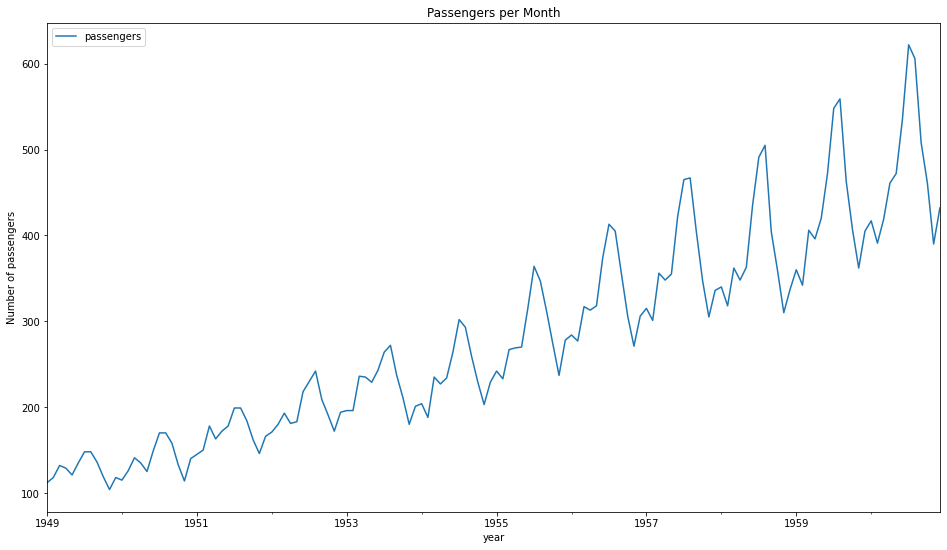

In [5]:
#Visualización de toda la secuencia ordenada
df.passengers.plot(figsize = (16, 9))
plt.title('Passengers per Month')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

# Exploración del conjunto de datos
Esta sección comprende las siguientes tareas:
- Descomposición de la serie Temporal.
- Verificación de la heterocedasticidad.
- Verificación de estacionalidad.



### Descomposición de la serie temporal:
En este inciso busca descomponer la serie de tiempo en sus componentes de **Tendencia**, **estacionalidad** y **residuos**.

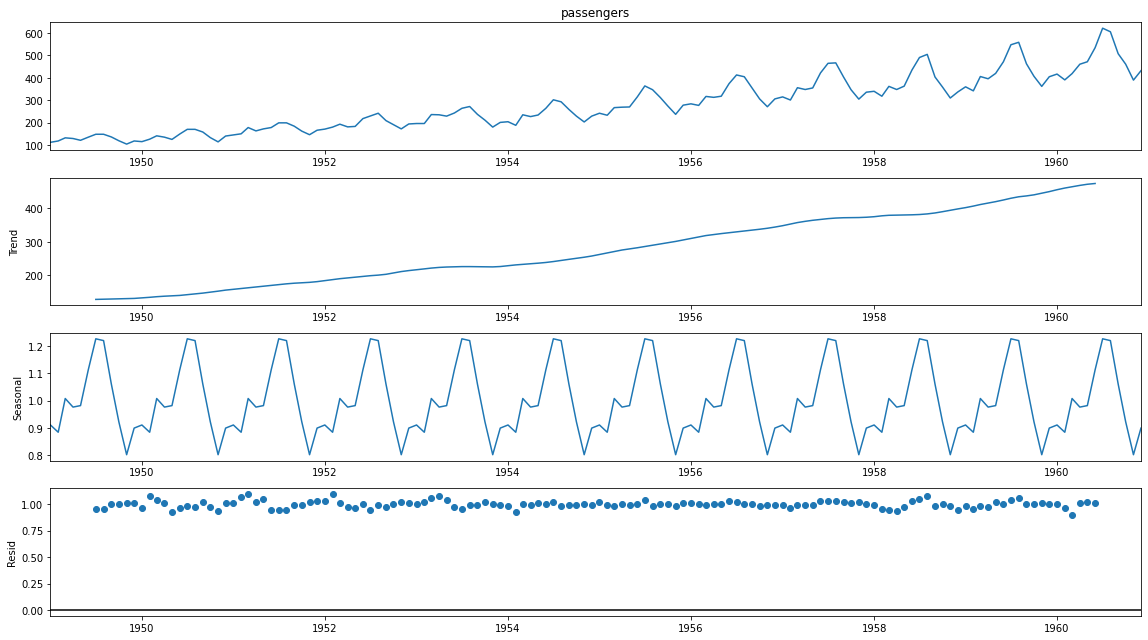

In [6]:
# descomposición de la serie temporal
decompose = sm.tsa.seasonal_decompose(df.passengers, model = 'multiplicative')
fig = decompose.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

### Heterocedasticidad


Text(0.5, 1.0, 'Varianza de la serie de tiempo')

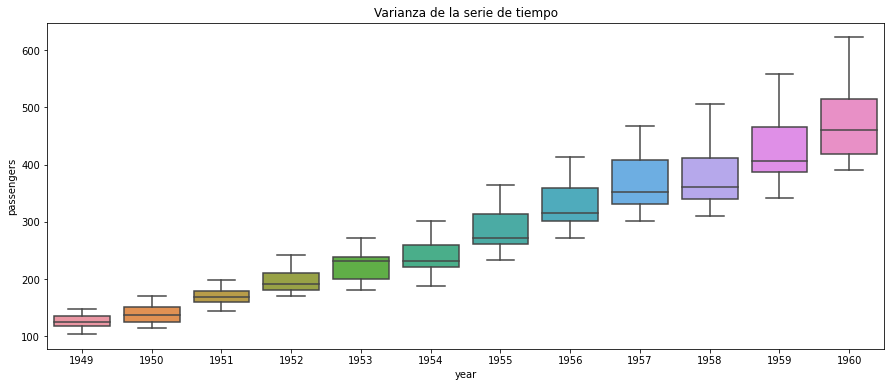

In [7]:
# Verificación de la heterocedasticidad (cambio de la varianza en el tiempo)
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df.passengers.index.year, df.passengers, ax = ax)
ax.set_title('Varianza de la serie de tiempo')

### Estacionariedad
Para verificar si la serie de tiempo es estacionaria se propone una **Hipótesis nula**.

#### Hipótesis nula
*   $H_{0}:$ Los datos son no estacionarios
*   $H_{1}:$ Los datos son estacionarios
*   Intervalo de confianza: $α = 0.05$

In [8]:
adtest = adfuller(df['passengers'], autolag = 'AIC')
df_test = pd.Series(adtest[0:2], index = ['Test', 'P-value'])
df_test

Test       0.815369
P-value    0.991880
dtype: float64

# Modelado de la serie de tiempo:
En esta sección se aplican los diferentes algoritmos de modelado.
- **SARIMAX** : Es un modelo auto regresivo integrado de medias móviles que contiene componentes estacionales y no estacionales,  es una mejora del modelo **SARIMA** encapsulado en variables de estado. 
- **FBprophet** : Es un paquete basado en Prophet mejorado por facebook, el cual, aplica modelado de series de tiempo basado en métodos frecuenciales, en adición, contiene muchas herramientas utiles para modelos complejos de series de tiempo, como inclusión de variables exógenas o eventos repetitivos denominados regresores.

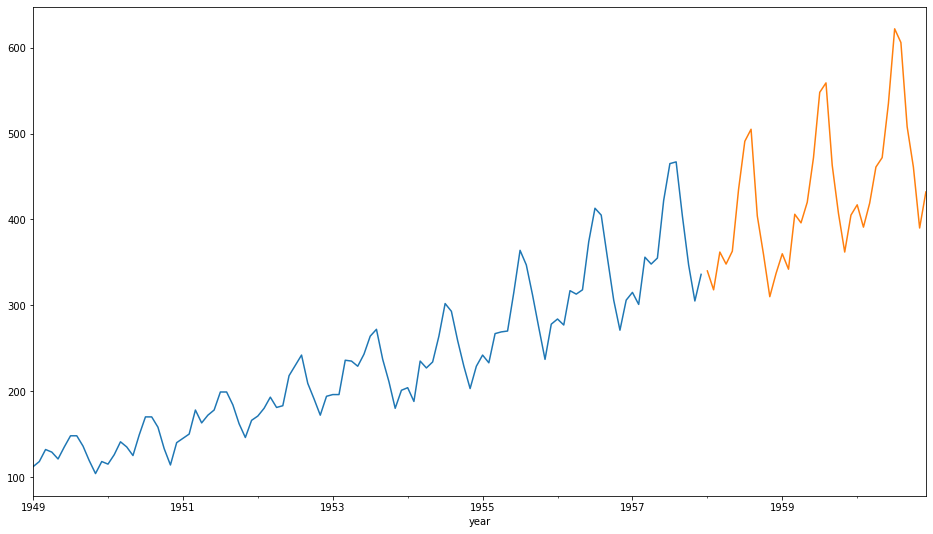

In [9]:
# Horizonte
horizonte = int(0.75*len(df.passengers))
train = df[:horizonte]
test = df[horizonte:]
# visualización
plt.figure(figsize = (16, 9))
train['passengers'].plot()
test['passengers'].plot()
plt.show()

### SARIMAX: 
La documentación de Sarimax está disponible [aquí](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

In [18]:
# SARIMAX Modificado: busca minimizar el Criterio de información de Akaike:
# es un estimador de la calidad relativa del modelo que tiene en cuenta su complejidad.

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #verificamos el mejor modelo : menor AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.7081717070782
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.267707006777
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.4755946445503
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.095889541804


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.2555893602133
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006279


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.1257357113416
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.491212125711


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.8780689458824
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.9733569845619


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884756611585
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.3727396780498


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.552024714264
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123025319
ARIMA(0, 1, 0)x(0, 1, 0, 6)12 - AIC:999.3755478803968


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(0, 1, 0)x(0, 1, 1, 6)12 - AIC:853.8944017377315
ARIMA(0, 1, 0)x(1, 0, 0, 6)12 - AIC:952.22563775069


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 0, 1, 6)12 - AIC:904.2214150938053
ARIMA(0, 1, 0)x(1, 1, 0, 6)12 - AIC:706.8180283967246
ARIMA(0, 1, 0)x(1, 1, 1, 6)12 - AIC:700.9697603933234
ARIMA(0, 1, 1)x(0, 0, 0, 6)12 - AIC:973.2055693626097


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(0, 1, 1)x(0, 0, 1, 6)12 - AIC:924.7899877818242
ARIMA(0, 1, 1)x(0, 1, 0, 6)12 - AIC:979.095106421312
ARIMA(0, 1, 1)x(0, 1, 1, 6)12 - AIC:837.3373300218514


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(0, 1, 1)x(1, 0, 0, 6)12 - AIC:941.4721477228294
ARIMA(0, 1, 1)x(1, 0, 1, 6)12 - AIC:886.8511031801464


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 0, 6)12 - AIC:698.3539185548046


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 1, 6)12 - AIC:682.4714093202084
ARIMA(1, 0, 0)x(0, 0, 0, 6)12 - AIC:1003.4820392779112


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 0)x(0, 0, 1, 6)12 - AIC:954.4289346675697
ARIMA(1, 0, 0)x(0, 1, 0, 6)12 - AIC:1001.1995622331219
ARIMA(1, 0, 0)x(0, 1, 1, 6)12 - AIC:862.1556791545054


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(1, 0, 0)x(1, 0, 0, 6)12 - AIC:954.2184484398831
ARIMA(1, 0, 0)x(1, 0, 1, 6)12 - AIC:905.0278354939203


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 0)x(1, 1, 0, 6)12 - AIC:707.3904075302183


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 0)x(1, 1, 1, 6)12 - AIC:707.4979558719333
ARIMA(1, 0, 1)x(0, 0, 0, 6)12 - AIC:983.8745153729689


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(0, 0, 1, 6)12 - AIC:935.4799365965281
ARIMA(1, 0, 1)x(0, 1, 0, 6)12 - AIC:976.5242009161167


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(0, 1, 1, 6)12 - AIC:844.8331735778193
ARIMA(1, 0, 1)x(1, 0, 0, 6)12 - AIC:943.501939269679


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 0, 1, 6)12 - AIC:884.0817229060973
ARIMA(1, 0, 1)x(1, 1, 0, 6)12 - AIC:700.1612840320838


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 0, 1)x(1, 1, 1, 6)12 - AIC:690.5229323455002
ARIMA(1, 1, 0)x(0, 0, 0, 6)12 - AIC:986.4207435070009
ARIMA(1, 1, 0)x(0, 0, 1, 6)12 - AIC:937.2676970229335
ARIMA(1, 1, 0)x(0, 1, 0, 6)12 - AIC:985.3821728074666


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(1, 1, 0)x(0, 1, 1, 6)12 - AIC:844.0590254404626
ARIMA(1, 1, 0)x(1, 0, 0, 6)12 - AIC:936.338864348636
ARIMA(1, 1, 0)x(1, 0, 1, 6)12 - AIC:893.6268860673268


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(1, 1, 0)x(1, 1, 0, 6)12 - AIC:692.5537522208166
ARIMA(1, 1, 0)x(1, 1, 1, 6)12 - AIC:690.3400926012181


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

ARIMA(1, 1, 1)x(0, 0, 0, 6)12 - AIC:970.838028710658
ARIMA(1, 1, 1)x(0, 0, 1, 6)12 - AIC:922.0887630236386
ARIMA(1, 1, 1)x(0, 1, 0, 6)12 - AIC:977.8777245169302


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 1, 6)12 - AIC:840.6216450674511
ARIMA(1, 1, 1)x(1, 0, 0, 6)12 - AIC:930.6378133664323


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 0, 1, 6)12 - AIC:886.2198394845046
ARIMA(1, 1, 1)x(1, 1, 0, 6)12 - AIC:693.0569052219605


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 6)12 - AIC:684.3818336127526


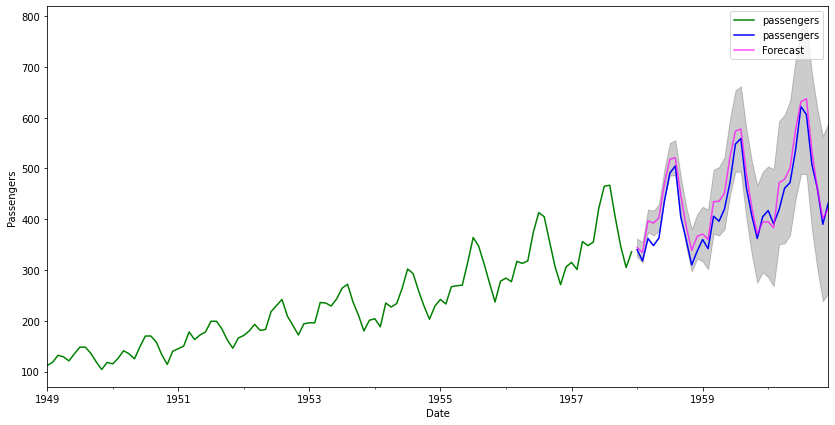

In [21]:
# Predicciones
start_index = test.index.min() 
end_index = test.index.max()
pred = min_aic_model.get_prediction(start = start_index,end = end_index, dynamic = False)
pred_ci = pred.conf_int()
ax = df.iloc[0:horizonte].plot(label ='observado', color = 'green')
df.iloc[horizonte:].plot(label='validación', ax = ax, color = 'blue')

# creación de la visualización
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7), color = 'magenta')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

### FBprophet:
La documentación del paquete se puede conseguir [aquí](https://facebook.github.io/prophet/).

In [12]:
# nuevo dataframe 
df_p = pd.read_csv(path, header = None)
# para fbprophet es necesario las siguientes condiciones:
# Columna Fecha -> renombrar a ds
# Columna y -> renombrar a y
df_p.columns = ['ds','y']
# ajustar formato de fechas
df_p['ds'] = pd.to_datetime(df_p['ds'], format='%Y-%m')

In [13]:
# creación del modelo
p_model =  Prophet()
p_model.fit(df_p)
# creación del dataframe de predicciones
future = p_model.make_future_dataframe(periods= len(test), freq = 'M' , include_history = True )
forecast = p_model.predict(future)
forecast = forecast[forecast['ds'] >= start_index]
forecast = forecast[forecast['ds'] <= end_index]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


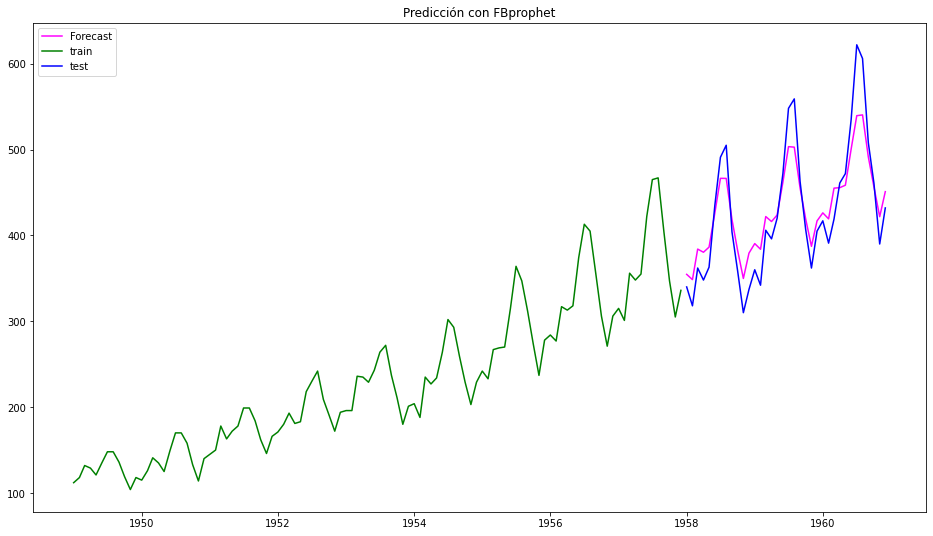

In [23]:
# visualización del resultado
plt.figure(figsize = (16, 9))

plt.plot(forecast['ds'], forecast['yhat'], 'magenta', label = 'Forecast')
plt.plot(train, 'green', label = 'train')
plt.plot(test, 'blue', label = 'test')
plt.legend()
plt.title('Predicción con FBprophet')
plt.show()

## Registro del Notebook

| Fecha (YYYY-MM-DD) | Versión | Revisado por | Descripción |Rol|
| ----------------- | ------- | ---------- | ------------|----------|
| 2023-02-28        | 1.0     |Sandro Miguel Calzada Berisso |Revisión |Senior Consultant (INDRA)|
|2023-02-27         | 1.0     | Juan Elías Marrugo Mercado | Creación del Notebook| Data Scientist (INDRA)|